In [ ]:
# Importation des packages et librairiie

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import seaborn as sns
import warnings

# word embedding
import string
import nltk
import gensim
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import string

# Téléchargement des ressources NLTK nécessaires (à faire une seule fois)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('all')

warnings.filterwarnings('ignore')

In [2]:
## Package pour entrainer notre percetron 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

#pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Chargement de la base PRC

In [3]:
data=pd.read_csv("PRC Data Breach Chronology_Download_May_2022.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9015 entries, 0 to 9014
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date Made Public         9015 non-null   object 
 1   Company                  9015 non-null   object 
 2   City                     5690 non-null   object 
 3   State                    8436 non-null   object 
 4   Type of breach           8926 non-null   object 
 5   Type of organization     9015 non-null   object 
 6   Total Records            9009 non-null   object 
 7   Description of incident  9012 non-null   object 
 8   Information Source       8962 non-null   object 
 9   Source URL               3607 non-null   object 
 10  Year of Breach           9015 non-null   int64  
 11  Latitude                 6541 non-null   float64
 12  Longitude                6541 non-null   float64
 13  Unnamed: 13              0 non-null      float64
 14  Unnamed: 14             

#### Préprocessing

In [5]:
data=pd.read_csv("PRC Data Breach Chronology_Download_May_2022.csv")
data['Total Records'] = pd.to_numeric(data['Total Records'], errors='coerce')
data['Date Made Public'] = pd.to_datetime(data['Date Made Public'], errors='coerce')
data['Year of Breach'] = pd.to_numeric(data['Year of Breach'], errors='coerce')

name={
    'Date Made Public':'Date_Made_Public',
    'Type of organization':'Type_of_organization',
    'Type of breach':'Type_of_breach',
    'Total Records':'Total_Records',
    'Year of Breach':'Year_of_Breach', 
    'Description of incident':'Description_of_incident'
}
data.rename(columns=name,inplace=True)

variables = [
    'Date_Made_Public',
    'Type_of_organization',
    'Type_of_breach',
    'Total_Records',
    'Year_of_Breach', 
    'Description_of_incident'
]
base_PRC=data[variables]


In [281]:
base_PRC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9015 entries, 0 to 9014
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date_Made_Public         9015 non-null   datetime64[ns]
 1   Type_of_organization     9015 non-null   object        
 2   Type_of_breach           8926 non-null   object        
 3   Total_Records            6446 non-null   float64       
 4   Year_of_Breach           9015 non-null   int64         
 5   Description_of_incident  9012 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 422.7+ KB


In [77]:
base_PRC.head(5)

,Date_Made_Public,Type_of_organization,Type_of_breach,Total_Records,Year_of_Breach,Description_of_incident
0,2006-03-03,BSF,HACK,88.0,2006,The company's website was breached sometime ar...
1,2012-01-04,BSF,PORT,0.0,2012,"The December 29, 2011 theft of a laptop from a..."
2,2012-02-18,BSR,PORT,0.0,2012,BDO was contracted by Rubio's to perform finan...
3,2012-02-22,BSF,HACK,0.0,2012,"On February 10, 2012, DHI Mortgage became awar..."
4,2012-03-12,MED,PORT,NaN,2012,An office burglary on New Year's Eve 2011 resu...


In [8]:
# Nombre de valeurs manquantes par variable
base_PRC.isna().sum().sort_values(ascending=False)

Total_Records              2569
Type_of_breach               89
Description_of_incident       3
Date_Made_Public              0
Type_of_organization          0
Year_of_Breach                0
dtype: int64

In [9]:
# Pourcentage de valeurs manquantes par variable (%)
100*base_PRC.isna().sum().sort_values(ascending=False)/base_PRC.shape[0]

Total_Records              28.496950
Type_of_breach              0.987243
Description_of_incident     0.033278
Date_Made_Public            0.000000
Type_of_organization        0.000000
Year_of_Breach              0.000000
dtype: float64

In [10]:
# Nombre d'observation ayant la valeur du number of records null 
print(100*len(base_PRC[base_PRC['Total_Records']==0])/base_PRC.shape[0],'% ')
base_PRC[base_PRC['Total_Records']==0].count()

24.259567387687188 % 


Date_Made_Public           2187
Type_of_organization       2187
Type_of_breach             2187
Total_Records              2187
Year_of_Breach             2187
Description_of_incident    2186
dtype: int64

Ce qu'on fait dans la suite, c'est supprimer les observations avec les valeurs nulles du numbers of record car il n'apporte aucune information sur la sévérité de l'attaque cyber, et aussi supprimer les 3 observations qui n'ont pas de description d'incidence cyber.

In [11]:
#base_PRC[base_PRC.duplicated()]

In [12]:
# Quelques petites statistiques
base_PRC.select_dtypes(['object']).describe()

,Type_of_organization,Type_of_breach,Description_of_incident
count,9015,8926,9012
unique,8,8,5916
top,MED,HACK,Location of breached information: Theft\nBusin...
freq,4343,2533,706


Ainsi il pourrait avoir des redondances dans la variable de description des incidences qui sera analysée ultérieurement 

In [13]:
# Base à analyser 
data_PRC=base_PRC[(base_PRC['Total_Records']!=0)&(~(base_PRC['Description_of_incident'].isna()))]

In [280]:
# Analyse du nombre de personnes affectées
data_PRC.select_dtypes(['float']).describe().style.format("{:.0f}")

,Total_Records
count,4258
mean,44923
std,1245671
min,1
25%,280
50%,808
75%,2900
max,78800000


La moyenne est très décalée par rapport à la médiane ce qui montre que notre variable qui évalue la sévérité d'une attaque cyber est à queue lourde. Le graphique qui suite conforte bien nos observations :

## Analyse de données 

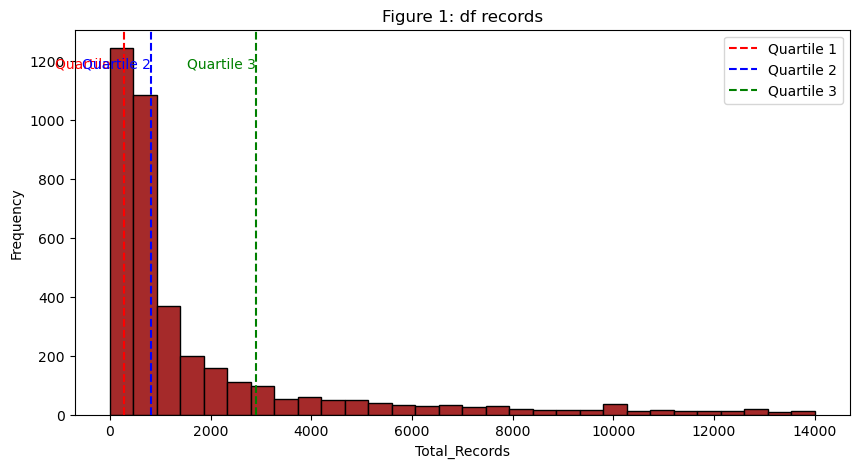

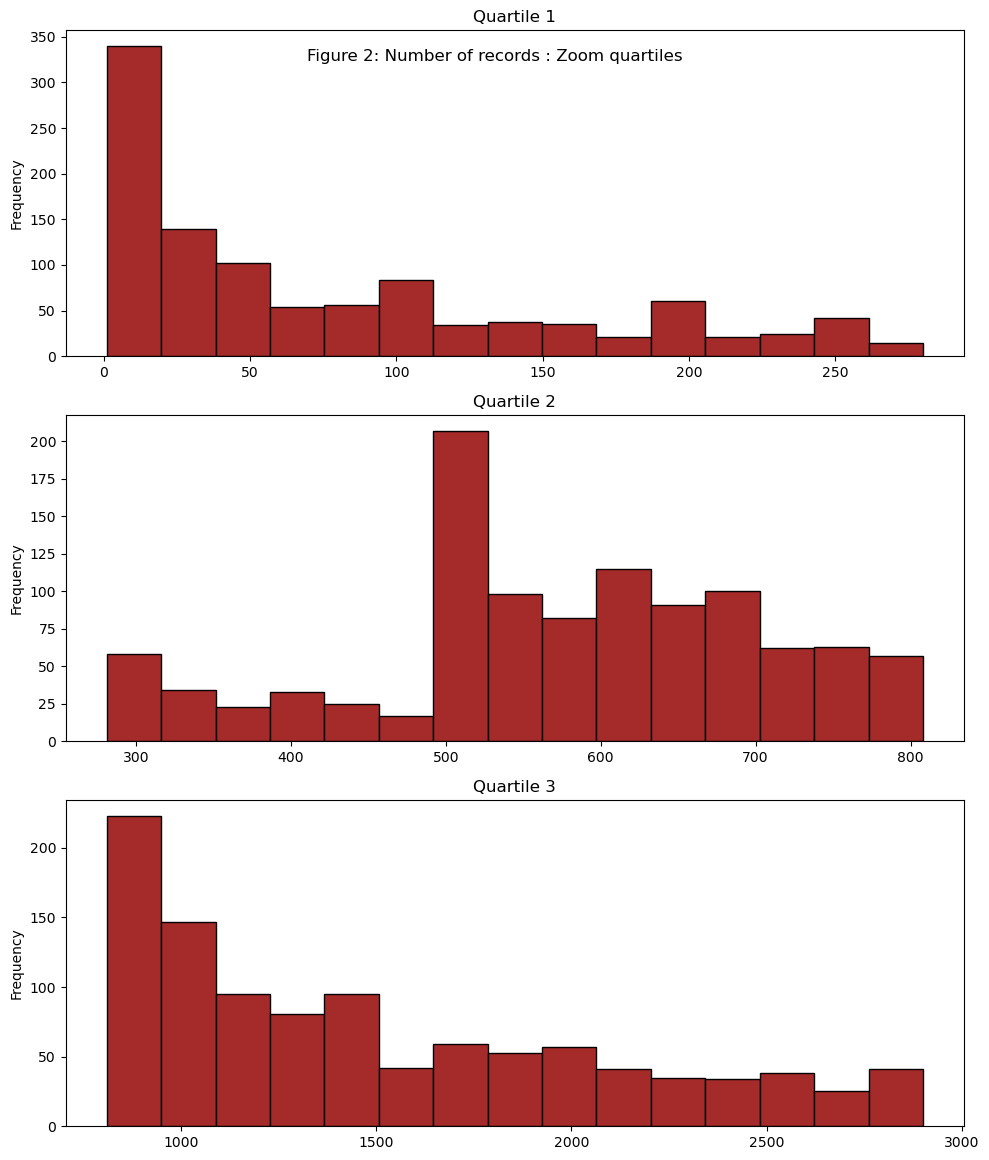

In [83]:
# Calcul des quartiles
q1 = data_PRC['Total_Records'].quantile(0.25)
q2 = data_PRC['Total_Records'].quantile(0.50)
q3 = data_PRC['Total_Records'].quantile(0.75)

# --- Figure 1 : Histogramme global avec lignes de quartiles ---
plt.figure(figsize=(10, 5))
q_data = data_PRC[(data_PRC['Total_Records'] <= 14000)]
plt.hist(q_data['Total_Records'], bins=30, color='brown', edgecolor='black')
plt.axvline(q1, color='red', linestyle='--', label='Quartile 1')
plt.axvline(q2, color='blue', linestyle='--', label='Quartile 2')
plt.axvline(q3, color='green', linestyle='--', label='Quartile 3')

plt.legend(loc='upper right')
plt.title('Figure 1: df records')
plt.xlabel('Total_Records')
plt.ylabel('Frequency')
plt.text(q1, plt.ylim()[1]*0.9, 'Quartile 1', color='red', ha='right')
plt.text(q2, plt.ylim()[1]*0.9, 'Quartile 2', color='blue', ha='right')
plt.text(q3, plt.ylim()[1]*0.9, 'Quartile 3', color='green', ha='right')
plt.show()

# --- Figure 2 : Zoom sur les quartiles ---
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Quartile 1
q1_data = data_PRC[data_PRC['Total_Records'] <= q1]
axs[0].hist(q1_data['Total_Records'], bins=15, color='brown', edgecolor='black')
axs[0].set_title('Quartile 1')

# Quartile 2
q2_data = data_PRC[(data_PRC['Total_Records'] > q1) & (data_PRC['Total_Records'] <= q2)]
axs[1].hist(q2_data['Total_Records'], bins=15, color='brown', edgecolor='black')
axs[1].set_title('Quartile 2')

# Quartile 3
q3_data = data_PRC[(data_PRC['Total_Records'] > q2) & (data_PRC['Total_Records'] <= q3)]
axs[2].hist(q3_data['Total_Records'], bins=15, color='brown', edgecolor='black')
axs[2].set_title('Quartile 3')

# Max
# q4_data = data_PRC[(data_PRC['Total_Records'] > q3)]
# axs[3].hist(q4_data['Total_Records'], bins=15, color='darkgreen', edgecolor='black')
# axs[3].set_title('Max')

for ax in axs:
    ax.set_ylabel('Frequency')

fig.suptitle('Figure 2: Number of records : Zoom quartiles', y=0.93)
plt.tight_layout()
plt.show()

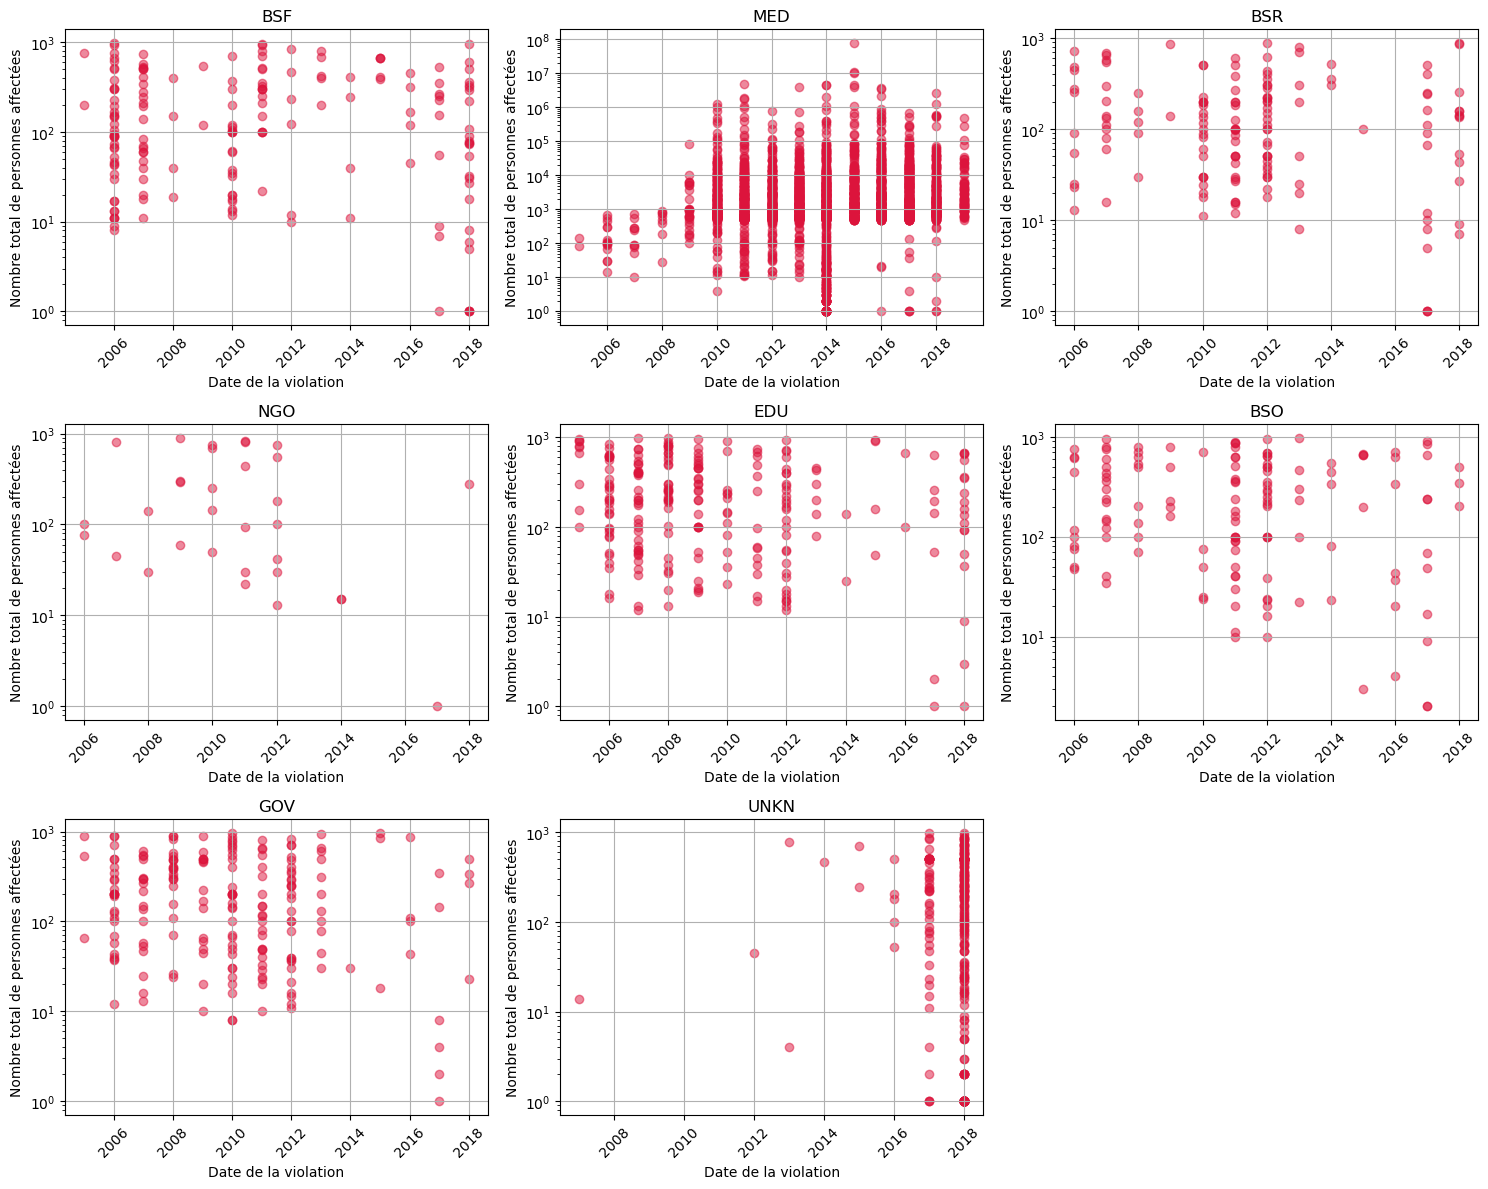

In [321]:
# Liste des types d'organisation uniques
unique_org_types = data_PRC['Type_of_organization'].unique()

# Définir la grille : 3 lignes, 3 colonnes
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12), sharex=False)

# Aplatir les axes pour itérer facilement
axes = axes.flatten()

# Tracer chaque sous-graphe
for i, org_type in enumerate(unique_org_types):
    ax = axes[i]
    subset = data_PRC[data_PRC['Type_of_organization'] == org_type]
    ax.scatter(subset['Year_of_Breach'], subset['Total_Records'], alpha=0.5,color='crimson')
    ax.set_yscale('log')
    ax.set_title(org_type)
    ax.set_xlabel('Date de la violation')
    ax.set_ylabel('Nombre total de personnes affectées')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)  # Rotation des dates pour lisibilité

# Supprimer les axes inutilisés s'il y a moins de 9 types
for j in range(len(unique_org_types), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [90]:
# Quantile 60%
Q40 = data_PRC['Total_Records'].quantile(0.6)
Q40

1168.3999999999996

In [91]:
import pandas as pd

# Calcul des statistiques descriptives groupées
stats = data_PRC.groupby('Type_of_organization')['Total_Records'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

# Renommer les colonnes pour correspondre au tableau souhaité
stats = stats.rename(columns={
    'count': 'Number',
    'mean': 'Mean',
    '25%': 'q0.25',
    '50%': 'Median',
    '75%': 'q0.75',
    '90%': 'q0.9',
    '95%': 'q0.95',
    'max': 'Max'
})
# Afficher le tableau
base=stats[['Number', 'Mean', 'q0.25', 'Median', 'q0.75', 'q0.9', 'q0.95', 'Max']]
base

,Number,Mean,q0.25,Median,q0.75,q0.9,q0.95,Max
Type_of_organization,,,,,,,,
BSF,175.0,233.480000,39.0,121.0,352.50,642.0,750.30,988.0
BSO,136.0,316.330882,73.0,230.0,532.50,725.0,848.75,979.0
BSR,149.0,187.456376,36.0,111.0,250.00,501.2,668.20,883.0
EDU,236.0,295.326271,59.5,200.0,492.25,734.5,850.25,990.0
GOV,200.0,273.615000,49.5,198.5,476.25,700.0,865.65,969.0
MED,3024.0,63148.680225,675.0,1488.5,5488.00,19202.1,50000.00,78800000.0
NGO,32.0,276.312500,39.0,120.0,471.75,795.7,812.60,900.0
UNKN,306.0,240.431373,5.0,150.0,500.00,565.5,728.00,989.0


#### Analyse du nombre d'incidences en fonction du type d'organisation touchée

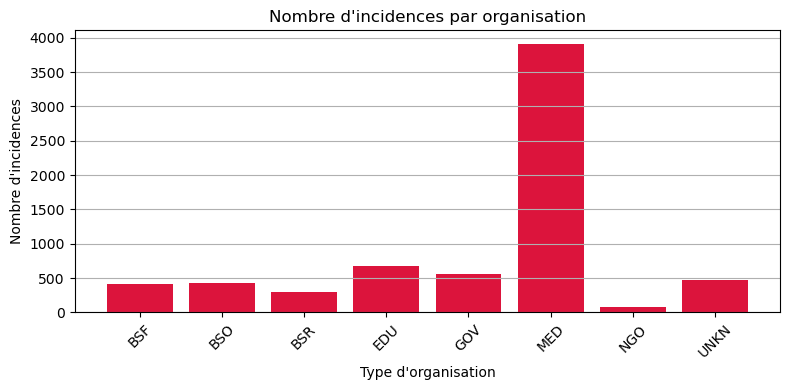

In [322]:
# Compter les occurrences par année
yearly_counts = data_PRC['Type_of_organization'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(8, 4))
plt.bar(yearly_counts.index, yearly_counts.values, color='crimson')

# Ajouter les étiquettes
plt.title("Nombre d'incidences par organisation")
plt.xlabel("Type d'organisation")
plt.ylabel("Nombre d'incidences")

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### Analyse du nombre d'incidences en fonction du type de brèche

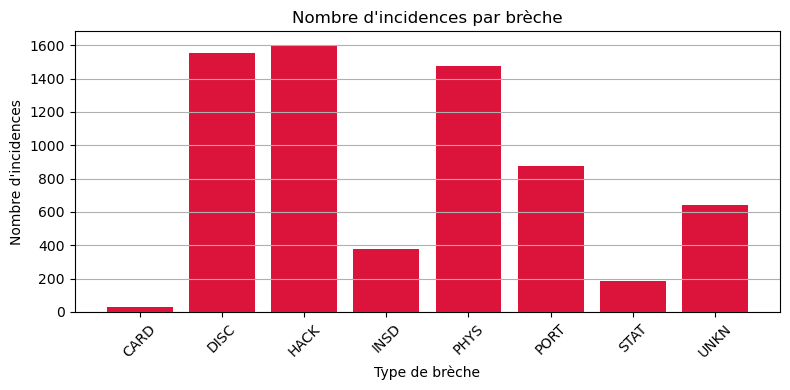

In [323]:

# Compter les occurrences par année
yearly_counts = data_PRC['Type_of_breach'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(8, 4))
plt.bar(yearly_counts.index, yearly_counts.values, color='crimson')

# Ajouter les étiquettes
plt.title("Nombre d'incidences par brèche")
plt.xlabel("Type de brèche")
plt.ylabel("Nombre d'incidences")

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Analyse du nombre d'incidences en fonction de l'année

In [98]:
data_PRC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6826 entries, 0 to 9014
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date_Made_Public         6826 non-null   datetime64[ns]
 1   Type_of_organization     6826 non-null   object        
 2   Type_of_breach           6737 non-null   object        
 3   Total_Records            4258 non-null   float64       
 4   Year_of_Breach           6826 non-null   int64         
 5   Description_of_incident  6826 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 373.3+ KB


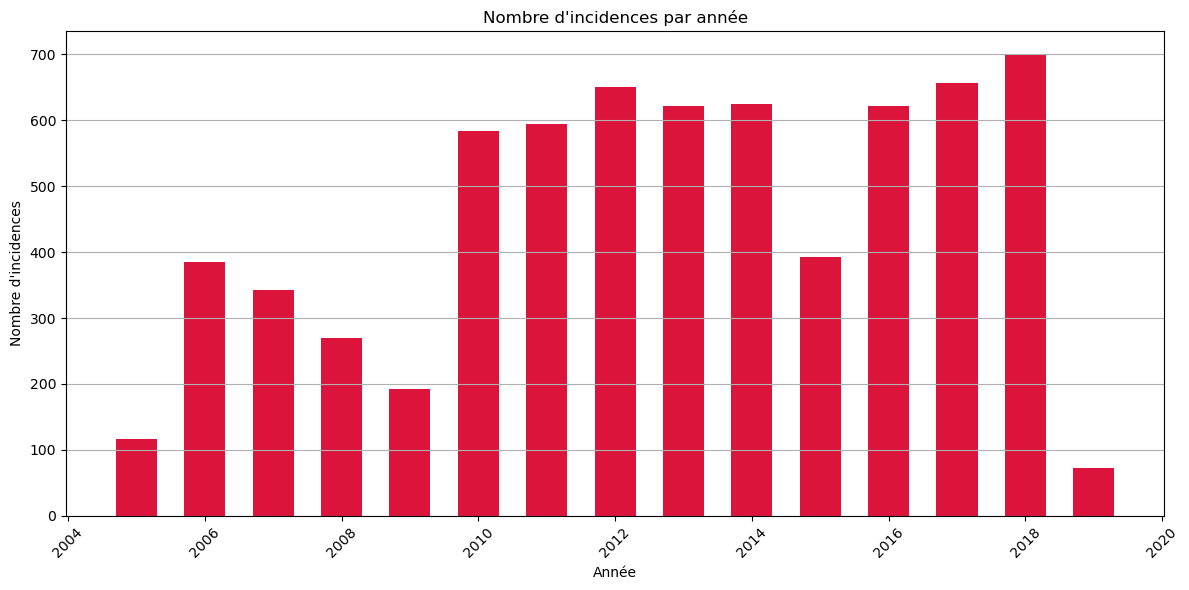

In [324]:
# Compter les occurrences par année
yearly_counts = data_PRC['Year_of_Breach'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts.index, yearly_counts.values, color='crimson',width=0.6)

# Ajouter les étiquettes
plt.title("Nombre d'incidences par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'incidences")

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Une analyse faite parmi les sinistres graves

In [127]:
# Selectionner les observations pour lesquelles le nombre de personnes affectées n'est pas manquant
data_PRC_model=data_PRC[~(data_PRC['Total_Records'].isna())]

On suppose que les sinistres graves sont des incidences dont le nombre total de personnes affectées est supérieur au 60ème percentile (Q60) de la distribution des sinistres.

In [128]:
Q40 = data_PRC_model['Total_Records'].quantile(0.6)
Q40

1168.3999999999996

In [130]:
#Filtrer les données pour ne garder que les sinistres grave soit ceux avec un nombre de personnes affectées supérieur au quantile 60%
data_PRC_model_grave = data_PRC_model[data_PRC_model['Total_Records'] > Q40]

#### Base des sinistres graves

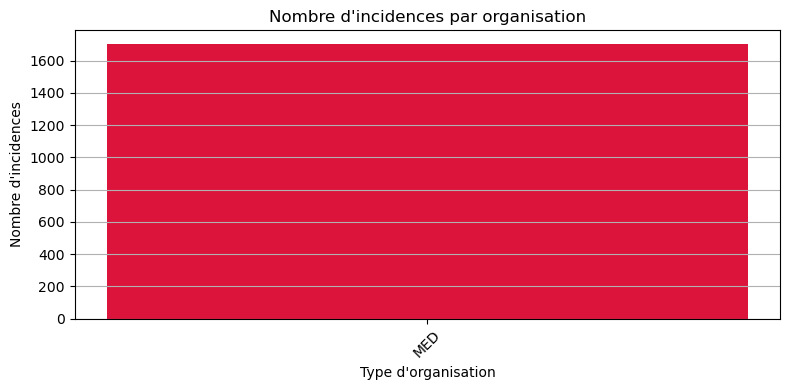

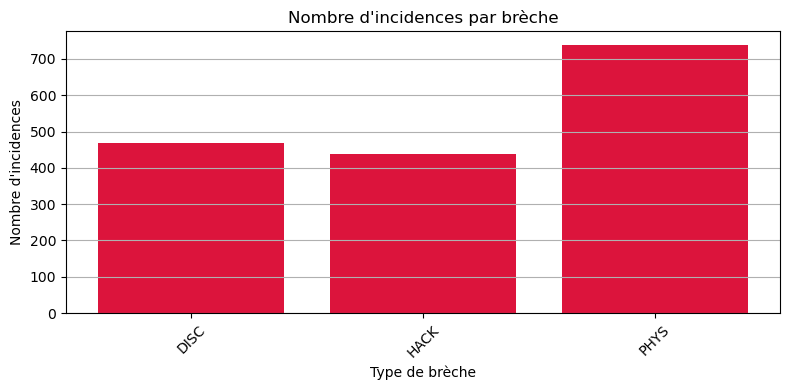

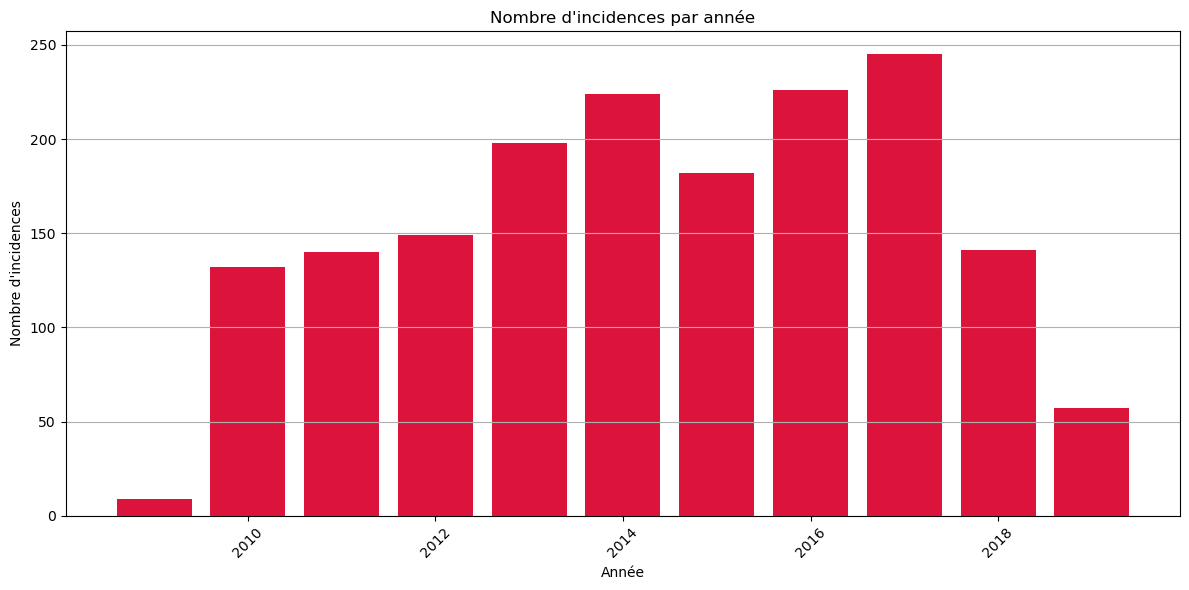

In [325]:
# Compter les occurrences par année
yearly_counts = data_PRC_model_grave['Type_of_organization'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(8, 4))
plt.bar(yearly_counts.index, yearly_counts.values, color='crimson')

# Ajouter les étiquettes
plt.title("Nombre d'incidences par organisation")
plt.xlabel("Type d'organisation")
plt.ylabel("Nombre d'incidences")

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Compter les occurrences par année
yearly_counts = data_PRC_model_grave['Type_of_breach'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(8, 4))
plt.bar(yearly_counts.index, yearly_counts.values, color='crimson')

# Ajouter les étiquettes
plt.title("Nombre d'incidences par brèche")
plt.xlabel("Type de brèche")
plt.ylabel("Nombre d'incidences")

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Compter les occurrences par année
yearly_counts = data_PRC_model_grave['Year_of_Breach'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts.index, yearly_counts.values, color='crimson',width=0.8)

# Ajouter les étiquettes
plt.title("Nombre d'incidences par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'incidences")

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Réseau de neurone 

### Word embeding Algorithme

#### Prétraitement : Nettoyage du corpus

In [ ]:
###### Analyse des descriptions des incidents

In [154]:
nb_duplicated = data_PRC_model[['Description_of_incident']].duplicated().sum()
print(f"Nombre de lignes dupliquées dans le DataFrame : {nb_duplicated}")

# Pour une liste Python
nb_duplicated_list =  len(set(data_PRC_model['Description_of_incident'].tolist()))
print(f"Nombre de valeurs non dupliquées dans la liste : {nb_duplicated_list}")

Nombre de lignes dupliquées dans le DataFrame : 2801
Nombre de valeurs non dupliquées dans la liste : 1457


In [ ]:
# data_PRC_model['Description_of_incident'][9012]
# data_PRC_model['Description_of_incident'][9011]
# data_PRC_model['Description_of_incident'][9014]

'Location of breached information: Theft\nBusiness associate present: No'

In [ ]:
# Fonction pour nettoyer le texte

#récupérer sous forme de liste
corpus = data_PRC_model['Description_of_incident'].tolist()

# Fonction pour nettoyer le texte
def preprocess_text(Corpus):
    def clean_text(text):
        
        # Supprimer les formats de date : "December 1, 2019"
        text = re.sub(r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}', '', text)
        
        # Supprimer les mois abrégés : "Dec 1, 2019"
        text = re.sub(r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\.?\s+\d{1,2},\s+\d{4}', '', text)
        
        # Supprimer les années seules : "2020", "1998"
        text = re.sub(r'\b\d{4}\b', '', text)
        
        # suppression carctères spéciaux
        text = re.sub(r'[^\w\s]', '', text)
        # Retirer les balises HTML
        text = re.sub(r'<.*?>', '', text)
        
        # Convertir en minuscules
        text = text.lower()
        # Supprimer la ponctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        #Supprimer les chiffres
        text = re.sub(r'\d+', '', text)
        
        # Tokenisation
        tokens = word_tokenize(text)
        # Supprimer les stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        # lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
        
        return lemmatized_words

    # Appliquer le prétraitement
    
    tokenized_corpus = [clean_text(doc) for doc in Corpus]
    
    # Bigrams
    bigram_model = Phrases(tokenized_corpus, min_count=5, threshold=25)  # Ajustez les paramètres selon vos besoins
    bigram_phraser = Phraser(bigram_model)
    bigram_sentences = [bigram_phraser[sent] for sent in tokenized_corpus]
    
    # Trigrams
    trigram_model = Phrases(bigram_sentences, min_count=5, threshold=25)  # Ajustez les paramètres selon vos besoins
    trigram_phraser = Phraser(trigram_model)
    trigram_sentences = [trigram_phraser[sent] for sent in bigram_sentences]

    # Appliquer le nettoyage à chaque description
    return trigram_sentences

##### Définition de la base definitive

In [ ]:
# incidents graves
corpus = data_PRC_model['Description_of_incident'].tolist()
# Prétraitement des descriptions des incidents graves
data_pretrained=preprocess_text(corpus)
# Importation des bibliothèques nécessaires
data_PRC_model['word']=data_pretrained

# création d'une nouvelle colonne 'niveau_gravite' basée sur le quantile 60%
data_PRC_model['niveau_gravite'] = np.where(data_PRC_model['Total_Records'] > Q40, 1, 0)

# Filtrer les données pour ne garder que les variables nécessaires
data_PRC_model_new = data_PRC_model[['word', 'niveau_gravite']].copy()


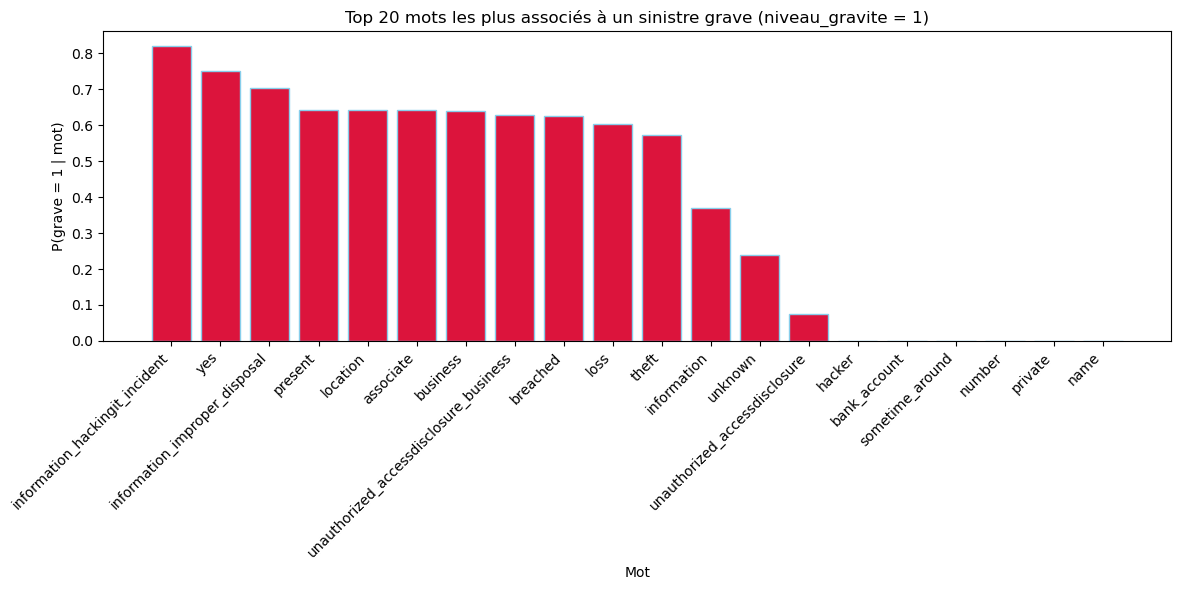

In [320]:
# Dictionnaires pour compter les occurrences
word_total_counts = defaultdict(int)
word_grave_counts = defaultdict(int)

# Boucle sur les lignes du DataFrame
for _, row in data_PRC_model_new.iterrows():
    niveau = row['niveau_gravite']
    unique_words = set(row['word'])  # pour éviter de compter plusieurs fois le même mot dans une ligne
    for word in unique_words:
        word_total_counts[word] += 1
        if niveau == 1:
            word_grave_counts[word] += 1

# Calcul des probabilités conditionnelles P(grave=1 | mot)
word_prob_grave = {
    word: word_grave_counts[word] / word_total_counts[word]
    for word in word_total_counts
    if word_total_counts[word] >= 5  # on filtre les mots trop rares pour éviter les biais
}

# On prend les top mots les plus corrélés à un grave=1
top_words = dict(sorted(word_prob_grave.items(), key=lambda x: x[1], reverse=True)[:20])

# Tracer le graphique
plt.figure(figsize=(12, 6))
plt.bar(top_words.keys(), top_words.values(), color='crimson', edgecolor='skyblue')
plt.title("Top 20 mots les plus associés à un sinistre grave (niveau_gravite = 1)")
plt.xlabel("Mot")
plt.ylabel("P(grave = 1 | mot)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


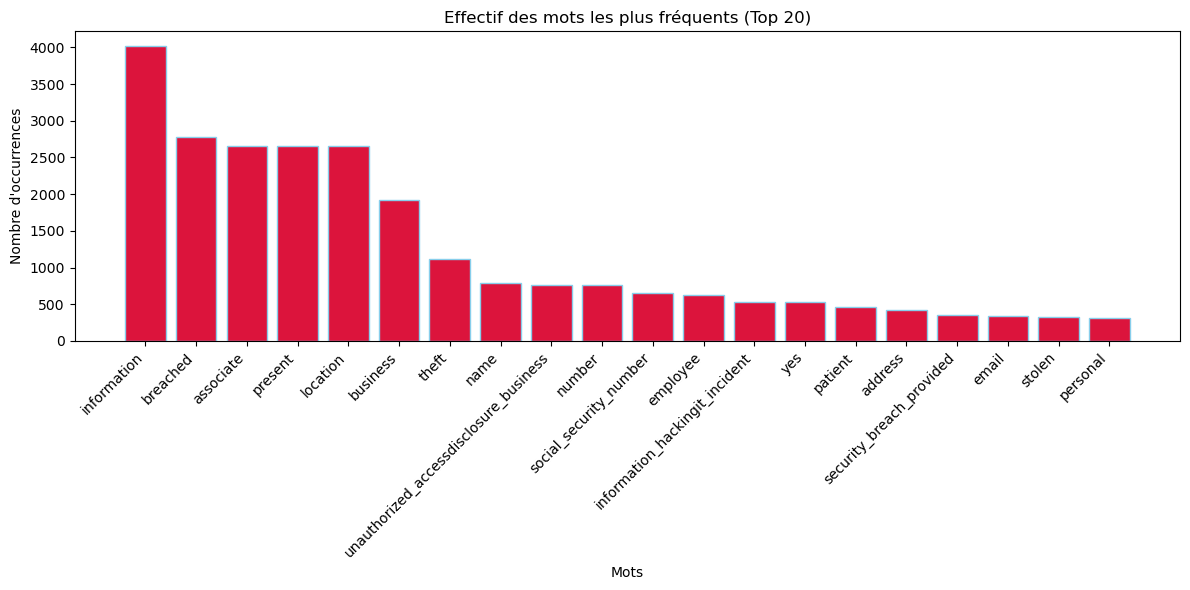

In [326]:


# Construction du vocabulaire à partir des tokens de data_pretrained
voc = []
for d in data_pretrained:
    for w in d:
        voc.append(w)

# Étape 1 : Compter les mots (effectifs)
word_counts = Counter(voc)

# Étape 2 : Extraire les 20 mots les plus fréquents
top_words = dict(word_counts.most_common(20))

# Étape 3 : Tracer l'histogramme des effectifs
plt.figure(figsize=(12, 6))
plt.bar(top_words.keys(), top_words.values(), color='crimson', edgecolor='skyblue')
plt.title("Effectif des mots les plus fréquents (Top 20)")
plt.xlabel("Mots")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [305]:
# # incidents graves
# corpus_grave = data_PRC_model_grave['Description_of_incident'].tolist()
# # Prétraitement des descriptions des incidents graves
# data_pretrained_grave=preprocess_text(corpus_grave)
# # construction du vocabulaire pour les incidents graves
# voc_grave = []
# for d in data_pretrained_grave:
#     for w in d :
#         voc_grave.append(w)


# # Étape 1 : Compter les mots
# word_counts = Counter(voc_grave)

# # Étape 2 : Total de mots pour obtenir la fréquence (proba)
# total_words = sum(word_counts.values())

# # Étape 3 : Calculer les fréquences (probabilités)
# word_frequencies = {word: count / total_words for word, count in word_counts.items()}

# # Étape 4 : Sélectionner les mots les plus fréquents (top 20 par exemple)
# top_words = dict(sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20])

# # Étape 5 : Tracer le graphique
# plt.figure(figsize=(12, 6))
# plt.bar(top_words.keys(), top_words.values(), color='brown', edgecolor='skyblue')
# plt.title("Probabilité d'apparition des mots (Top 20) - Incidents graves")
# plt.xlabel("Mots")
# plt.ylabel("Probabilité")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

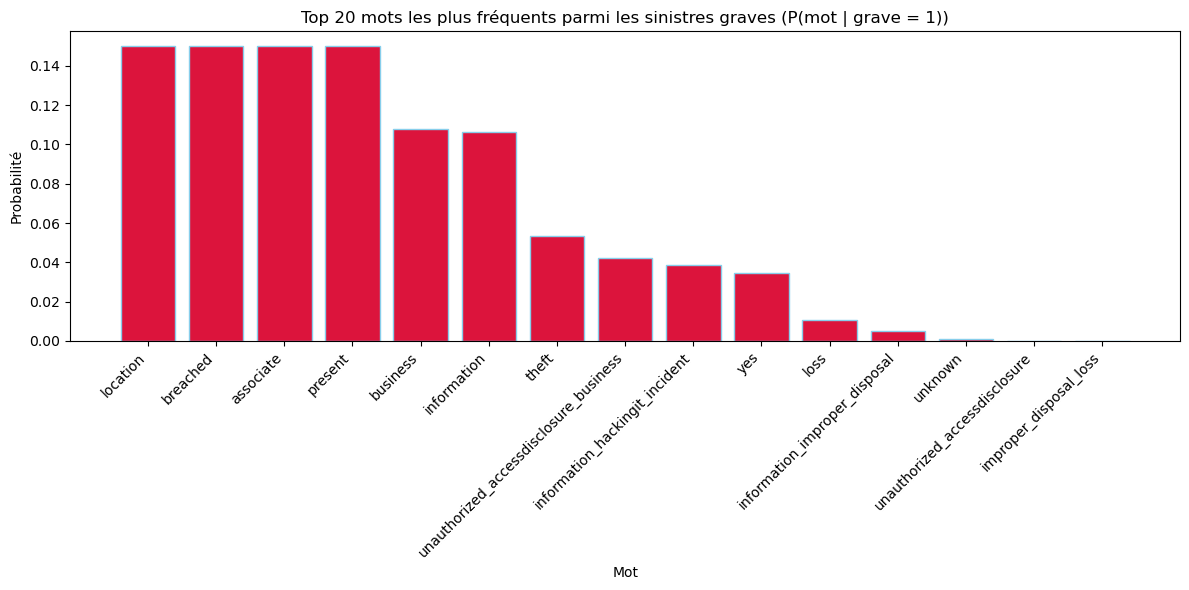

In [328]:

# Étape 1 : filtrer les sinistres graves
grave_rows = data_PRC_model_new[data_PRC_model_new['niveau_gravite'] == 1]

# Étape 2 : extraire tous les mots
grave_words = []
for words in grave_rows['word']:
    grave_words.extend(words)  # concatène toutes les listes de mots

# Étape 3 : compter les occurrences
grave_counts = Counter(grave_words)
total_grave_words = sum(grave_counts.values())  # total de mots dans grave=1

# Étape 4 : calculer les probabilités
grave_frequencies = {
    word: count / total_grave_words
    for word, count in grave_counts.items()
}

# Étape 5 : sélectionner les top 20
top_grave_words = dict(sorted(grave_frequencies.items(), key=lambda x: x[1], reverse=True)[:20])

# Étape 6 : tracer le graphique
plt.figure(figsize=(12, 6))
plt.bar(top_grave_words.keys(), top_grave_words.values(), color='crimson', edgecolor='SkyBlue')
plt.title("Top 20 mots les plus fréquents parmi les sinistres graves (P(mot | grave = 1))")
plt.xlabel("Mot")
plt.ylabel("Probabilité")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


####  Word2Vec avec Gensim proprement dit

In [307]:
#word2vec
from gensim.models import Word2Vec
modele = Word2Vec(data_pretrained,min_count=1,vector_size=2,window=5)

In [308]:
#propriété "wv" -> wordvector
words = modele.wv

#affichage des termes de leur index
words.key_to_index

{'information': 0,
 'breached': 1,
 'associate': 2,
 'present': 3,
 'location': 4,
 'business': 5,
 'theft': 6,
 'name': 7,
 'unauthorized_accessdisclosure_business': 8,
 'number': 9,
 'social_security_number': 10,
 'employee': 11,
 'information_hackingit_incident': 12,
 'yes': 13,
 'patient': 14,
 'address': 15,
 'security_breach_provided': 16,
 'email': 17,
 'stolen': 18,
 'personal': 19,
 'laptop': 20,
 'office_indiana_attorney_general': 21,
 'account': 22,
 'may': 23,
 'computer': 24,
 'student': 25,
 'contained': 26,
 'record': 27,
 'breach': 28,
 'affected': 29,
 'customer': 30,
 'exposed': 31,
 'data': 32,
 'included': 33,
 'loss': 34,
 'file': 35,
 'credit_card': 36,
 'office': 37,
 'people': 38,
 'used': 39,
 'service': 40,
 'discovered': 41,
 'website': 42,
 'former': 43,
 'two': 44,
 'individual': 45,
 'identity': 46,
 'health': 47,
 'one': 48,
 'client': 49,
 'accessed': 50,
 'sent': 51,
 'hospital': 52,
 'also': 53,
 'found': 54,
 'department': 55,
 'system': 56,
 'state':

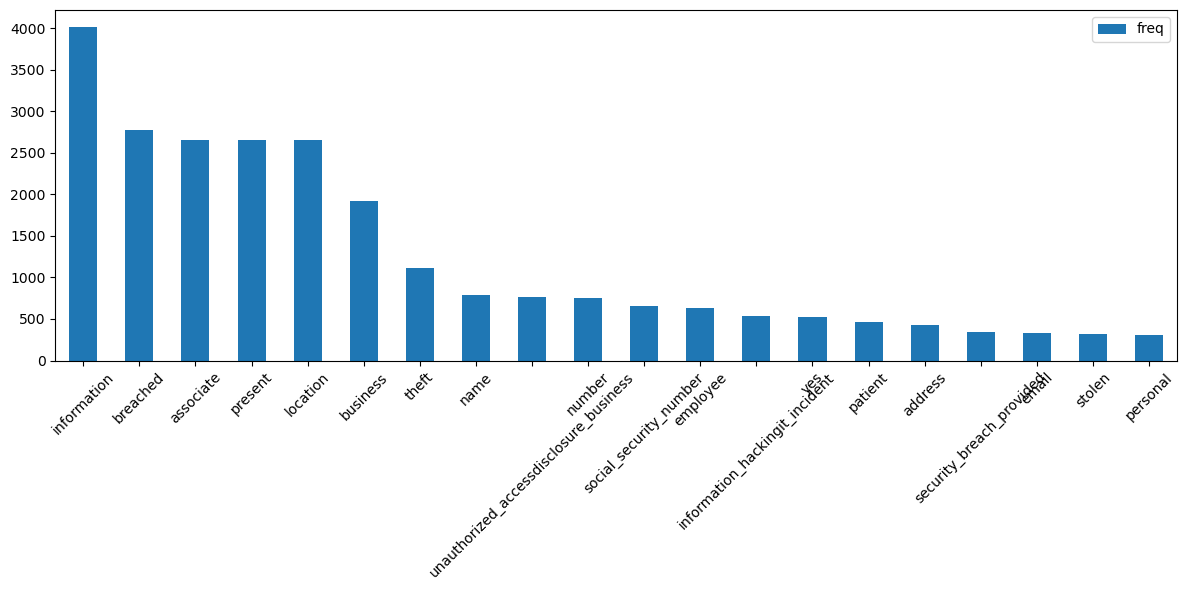

In [310]:
# initialisation de l'histogramme
freq = dict()
for v in list(words.index_to_key):
    freq[v] = 0
    
# comptage des occurrences
for d in data_pretrained:
    for w in d:
        freq[w] += 1

d=dict(list(freq.items())[:20])
df1 = pd.DataFrame({'freq':d.values()}, index=d.keys())

ax = df1.plot.bar(rot=45,figsize=(12, 6))
ax.tick_params(axis='x', labelsize=10)  # ajuster la taille des étiquettes
plt.tight_layout()
plt.show()

In [312]:
#coordonnées 
vec2 = words['social_security']
print(vec2)
vec1 = words['information']
print(vec1)

[1.2267344 1.5553724]
[-1.1548941  4.8713155]


In [315]:
print(np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))

0.62113965


In [316]:
#similarité de gensim
words.similarity('information','social_security')

0.62113976

In [317]:
#les termes les plus proches de "boring"
words.most_similar("social_security",topn=20)

[('st', 1.0),
 ('portal', 1.0),
 ('early_september', 1.0),
 ('louis', 1.0),
 ('welfare', 0.9999999403953552),
 ('produced', 0.9999997615814209),
 ('generic', 0.9999997019767761),
 ('street', 0.9999997019767761),
 ('least_new_york_resident', 0.9999997019767761),
 ('reviewing', 0.9999996423721313),
 ('floridian', 0.9999990463256836),
 ('positive', 0.9999983310699463),
 ('planned', 0.9999975562095642),
 ('marked', 0.9999975562095642),
 ('create', 0.9999964833259583),
 ('encrypted', 0.9999959468841553),
 ('conspirator', 0.9999958872795105),
 ('nerve', 0.9999949932098389),
 ('leave', 0.9999947547912598),
 ('recycled', 0.9999939203262329)]

In [319]:
#les termes les plus proches de "boring"
words.most_similar("location",topn=20)

[('payer', 1.0),
 ('indicates', 0.9999997615814209),
 ('burglaryfox', 0.9999995827674866),
 ('resuscitation', 0.9999991655349731),
 ('breached', 0.9999974966049194),
 ('employer', 0.9999964237213135),
 ('business', 0.9999951124191284),
 ('attending', 0.9999938607215881),
 ('bid', 0.9999882578849792),
 ('coordinator', 0.9999880194664001),
 ('traveling', 0.9999843835830688),
 ('fire', 0.999982476234436),
 ('solicitor', 0.9999823570251465),
 ('information', 0.9999783635139465),
 ('bbc', 0.9999762773513794),
 ('totalling', 0.9999750852584839),
 ('backpack', 0.9999746084213257),
 ('gb', 0.9999733567237854),
 ('associate', 0.9999719858169556),
 ('manipulate', 0.999969482421875)]

In [50]:
# récupérer les données dans un data frame
df = pd.DataFrame(words.vectors,columns=['V1','V2'],index=words.key_to_index.keys())
print(df)

                                         V1        V2
breach_involving                  -0.012723  0.015734
consumer_affairs                   0.269479  0.456147
massachusetts_office              -0.455890 -0.356401
social_security                    0.353540  0.455176
business_regulation_reported_data -0.234115 -0.182212
...                                     ...       ...
west                               0.323891  0.472847
virginia                           0.355740  0.338816
claims                             0.069566 -0.487928
government                         0.233742 -0.026699
numbers_financial                  0.321646  0.089676

[803 rows x 2 columns]


In [51]:
#quelques mots clés
mots = ['breach_involving','social_security','debit_numbers','numbers_ssns','protected_health','provided','involving_unauthorized']
dfMots = df.loc[mots,:]
print(dfMots)

                              V1        V2
breach_involving       -0.012723  0.015734
social_security         0.353540  0.455176
debit_numbers           0.404362 -0.346531
numbers_ssns            0.084686  0.094502
protected_health        0.470189  0.335217
provided                0.311466 -0.074443
involving_unauthorized  0.512732 -0.214852


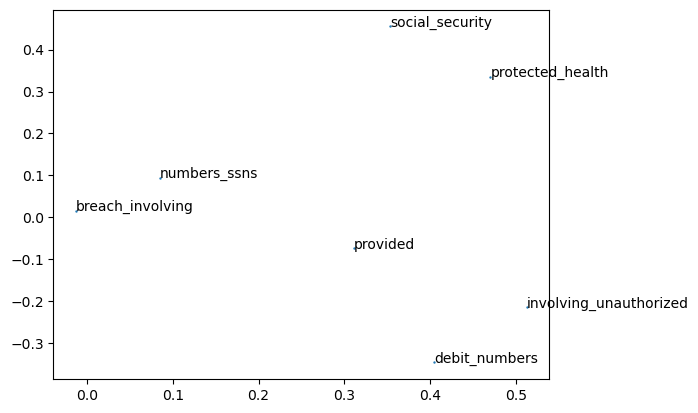

In [52]:
#graphique dans le plan
import matplotlib.pyplot as plt
plt.scatter(dfMots.V1,dfMots.V2,s=0.5)
for i in range(dfMots.shape[0]):
    plt.annotate(dfMots.index[i],(dfMots.V1[i],dfMots.V2[i]))
plt.show()

#### Coordonnées des documents à partir des termes

In [53]:
#fonction pour transformer un document en vecteur
#à partir des tokens qui le composent
#entrée : doc à traiter
#         modèle préentrainé
#sortie : vecteur représentant le document
def my_doc_2_vec(doc,trained):
    #dimension de représentation
    p = trained.vectors.shape[1]
    #initialiser le vecteur
    vec = np.zeros(p)
    #nombre de tokens trouvés
    nb = 0
    #traitement de chaque token du document
    for tk in doc:
        #ne traiter que les tokens reconnus
        try:
            values = trained[tk]
            vec = vec + values
            nb = nb + 1.0
        except:
            pass
    #faire la moyenne des valeurs
    #uniquement si on a trové des tokens reconnus bien sûr
    if (nb > 0.0):
        vec = vec/nb
    #renvoyer le vecteur
    #si aucun token trouvé, on a un vecteur de valeurs nulles
    return vec

In [54]:
#traiter les documents du corpus corpus
docsVec = list()
#pour chaque document du corpus nettoyé
for doc in trigrams:
    #calcul de son vecteur
    vec = my_doc_2_vec(doc,words)
    #ajouter dans la liste
    docsVec.append(vec)
#transformer en matrice numpy
matVec = np.array(docsVec)
print(matVec.shape)

(100, 2)


In [55]:
#transformer en data frame
df2 = pd.DataFrame(matVec,columns=["v"+str(i+1) for i in range(matVec.shape[1])])
df2['label'] = D.label
df2.head()

NameError: name 'D' is not defined

<Axes: xlabel='v1', ylabel='v2'>

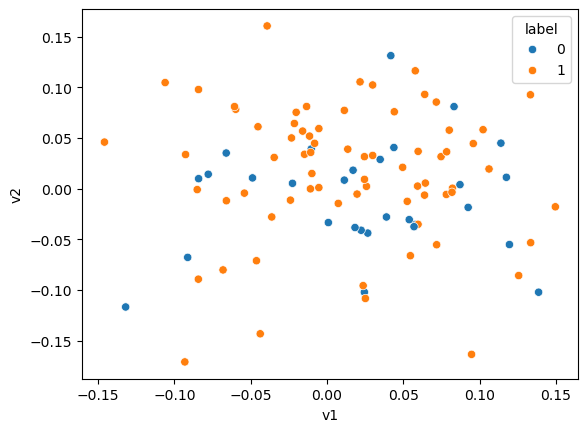

In [ ]:
#refaire le graphique avec la polarité
sns.scatterplot(data=df2,x='v1',y='v2',hue='label')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       100 non-null    object 
 1   organization_type        100 non-null    object 
 2   incident_details         100 non-null    object 
 3   breach_type              100 non-null    object 
 4   reported_date            100 non-null    object 
 5   breach_date              100 non-null    object 
 6   end_breach_date          100 non-null    object 
 7   total_affected           48 non-null     float64
 8   residents_affected       100 non-null    object 
 9   breach_location_city     100 non-null    object 
 10  breach_location_state    100 non-null    object 
 11  breach_location_country  100 non-null    object 
dtypes: float64(1), object(11)
memory usage: 9.5+ KB


# Doc2Vec avec gensim

In [ ]:
# Réorganiser la base de données 
D = df3[['incident_details', 'total_affected']].copy()  # on extrait les colonnes utiles
D['id'] = range(1, len(D) + 1)  # création de la colonne id de 1 à N

# Définir un seuil K
# Quantile 60%
K = df['total_affected'].quantile(0.6)

# Remplacer les valeurs manquantes (NaN) dans total_affected par 0 ou 1 aléatoirement
D['total_affected'] = D['total_affected'].apply(
    lambda x: x if pd.notnull(x) else np.random.choice(range(1, int(max(df['total_affected']))))
)
# Création de la variable label
D['label'] = (D['total_affected'] > K).astype(int)  # 1 si > K, sinon 0

# Remplacer les valeurs manquantes (NaN) dans total_affected par 0 ou 1 aléatoirement
D['total_affected'] = D['total_affected'].apply(
    lambda x: x if pd.notnull(x) else np.random.choice([0, 1])
)

In [ ]:
# Réorganiser les colonnes 
D = D[['id', 'incident_details', 'label']]

# Affichage
D

,id,incident_details,label
0,1,The Indiana Office of the Attorney General rep...,1
1,2,"On February 25, 2021, the Maryland Office of t...",0
2,3,The California Office of the Attorney General ...,1
3,4,"On October 9, 2018, the Minnesota Department o...",1
4,5,The Montana Department of Justice reported on ...,1
...,...,...,...
95,96,The Montana Department of Justice reported a d...,1
96,97,The California Office of the Attorney General ...,1
97,98,The California Office of the Attorney General ...,1
98,99,The Maine Office of the Attorney General repor...,1


In [ ]:
#tagger les documents avec leur identifiant
from gensim.models.doc2vec import TaggedDocument
tagged_docs = [TaggedDocument(words=trigrams[i],tags=["d"+str(D.id[i])]) for i in range(len(trigrams))]

#premier doc par ex.
print(tagged_docs[0])

TaggedDocument<['indiana_office', 'attorney_general_reported', 'des', 'moines', 'area', 'community_college', 'experienced_data_breach_affecting', 'total', '1,976', 'individuals', '11', 'residents_indiana', 'breach_notification', 'reported'], ['d1']>


In [ ]:
tagged_docs[1]

TaggedDocument(words=['maryland_office', 'attorney_general_reported_data', 'breach_involving', 'wms', 'partners', 'llc', 'occurred_due', 'phishing', 'breach_affected', '383', 'maryland_residents', 'potentially_compromising', 'personal_information', 'names', 'physical', 'addresses', 'account_numbers', 'last', 'four', 'digits', 'social_security', 'numbers', 'dates_birth', 'driver_’', 'license_numbers'], tags=['d2'])

In [ ]:
#doc2vec
from gensim.models.doc2vec import Doc2Vec
modeleDoc = Doc2Vec(vector_size=2,min_count=1,window=5)

#construction de dictionnaire dans un premier temps
modeleDoc.build_vocab(tagged_docs)

In [ ]:
#coordonnées des termes - comme avec doc2vec
pd.DataFrame(modeleDoc.wv.vectors,columns=['V1','V2'],index=modeleDoc.wv.key_to_index.keys())

,V1,V2
breach_involving,-0.026811,0.011822
consumer_affairs,0.255167,0.450464
massachusetts_office,-0.465147,-0.355840
social_security,0.322944,0.448649
business_regulation_reported_data,-0.250771,-0.188169
...,...,...
west,0.320888,0.471904
virginia,0.352764,0.337748
claims,0.065008,-0.490215
government,0.229388,-0.026911


In [ ]:
#modélisation pour le positionnement des documents
modeleDoc.train(tagged_docs,total_examples=modeleDoc.corpus_count,epochs=100)
print(modeleDoc.dv)

KeyedVectors<vector_size=2, 100 keys>


In [ ]:
#coordonnées des documents
print(modeleDoc.dv.key_to_index)

{'d1': 0, 'd2': 1, 'd3': 2, 'd4': 3, 'd5': 4, 'd6': 5, 'd7': 6, 'd8': 7, 'd9': 8, 'd10': 9, 'd11': 10, 'd12': 11, 'd13': 12, 'd14': 13, 'd15': 14, 'd16': 15, 'd17': 16, 'd18': 17, 'd19': 18, 'd20': 19, 'd21': 20, 'd22': 21, 'd23': 22, 'd24': 23, 'd25': 24, 'd26': 25, 'd27': 26, 'd28': 27, 'd29': 28, 'd30': 29, 'd31': 30, 'd32': 31, 'd33': 32, 'd34': 33, 'd35': 34, 'd36': 35, 'd37': 36, 'd38': 37, 'd39': 38, 'd40': 39, 'd41': 40, 'd42': 41, 'd43': 42, 'd44': 43, 'd45': 44, 'd46': 45, 'd47': 46, 'd48': 47, 'd49': 48, 'd50': 49, 'd51': 50, 'd52': 51, 'd53': 52, 'd54': 53, 'd55': 54, 'd56': 55, 'd57': 56, 'd58': 57, 'd59': 58, 'd60': 59, 'd61': 60, 'd62': 61, 'd63': 62, 'd64': 63, 'd65': 64, 'd66': 65, 'd67': 66, 'd68': 67, 'd69': 68, 'd70': 69, 'd71': 70, 'd72': 71, 'd73': 72, 'd74': 73, 'd75': 74, 'd76': 75, 'd77': 76, 'd78': 77, 'd79': 78, 'd80': 79, 'd81': 80, 'd82': 81, 'd83': 82, 'd84': 83, 'd85': 84, 'd86': 85, 'd87': 86, 'd88': 87, 'd89': 88, 'd90': 89, 'd91': 90, 'd92': 91, 'd93':

In [ ]:
#data frame avec les coordonnées
dfDoc2Vec = pd.DataFrame(modeleDoc.dv.vectors,columns=['X1','X2'])
print(dfDoc2Vec)

          X1        X2
0   0.648915 -2.929711
1   1.466017 -1.769099
2   1.799427 -2.023257
3   2.455747 -3.107562
4   1.311184 -1.557100
..       ...       ...
95  1.654263 -1.783042
96  3.446244 -1.153967
97  0.666839 -2.036388
98  1.841621 -1.304346
99  2.465158 -0.847800

[100 rows x 2 columns]


<Axes: xlabel='X1', ylabel='X2'>

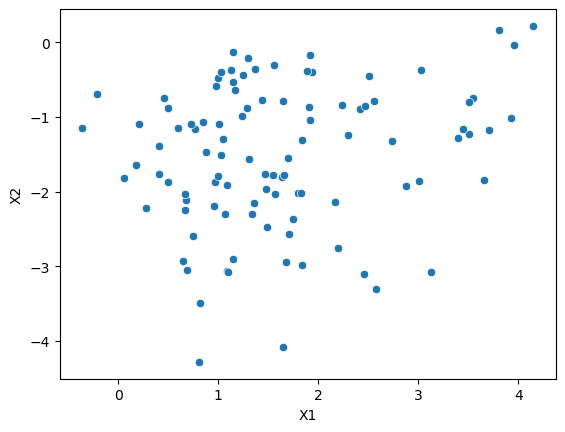

In [ ]:
#graphique
import seaborn as sns
sns.scatterplot(data=dfDoc2Vec,x='X1',y='X2')

In [ ]:
dfDoc2Vec

,X1,X2,polarite
0,0.648915,-2.929711,1
1,1.466017,-1.769099,0
2,1.799427,-2.023257,1
3,2.455747,-3.107562,1
4,1.311184,-1.557100,1
...,...,...,...
95,1.654263,-1.783042,1
96,3.446244,-1.153967,1
97,0.666839,-2.036388,1
98,1.841621,-1.304346,1


<Axes: xlabel='X1', ylabel='X2'>

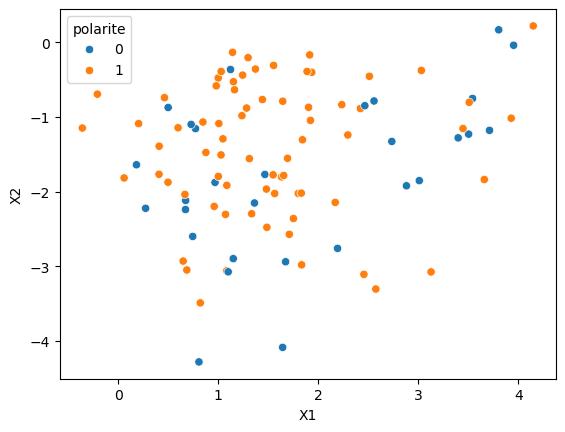

In [ ]:
#ajouter la polarité
dfDoc2Vec['polarite'] = D.label

#refaire le graphique avec la polarité
sns.scatterplot(data=dfDoc2Vec,x='X1',y='X2',hue='polarite')

### Prédiction et évaluation en test

##### Résultat  avec le modèle de vectorisation Word2vec

Il sera important tout d'abord important de subdiviser notre base de données en deux échantillons (Tran, Test) avant d'entraitner le modèle Word2vec.

C'est sur cette bases d'entrainement que sera calibrer notre perceptron multicouche et par la suite l'échantillon de test sera vectorisé et tester sur le perceptron

Ici nous N'observons pas cette démarche et splitons la base entière qui a été vectorisée dès le debut à savour la base : 

In [ ]:
df2

,v1,v2,label
0,-0.043817,-0.143127,1
1,0.024397,-0.102080,0
2,-0.016043,0.056789,1
3,0.025773,0.002279,1
4,0.071744,-0.055290,1
...,...,...,...
95,0.049475,0.021046,1
96,-0.008186,0.044711,1
97,0.024467,0.009160,1
98,-0.005413,0.059268,1


c:\Users\FranckOséeDOUNTIOZAB\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
✅ Accuracy: 0.7500
✅ F1-score: 0.8571

📊 Rapport complet :

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.75      1.00      0.86        15

    accuracy                           0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20



c:\Users\FranckOséeDOUNTIOZAB\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\FranckOséeDOUNTIOZAB\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\FranckOséeDOUNTIOZAB\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

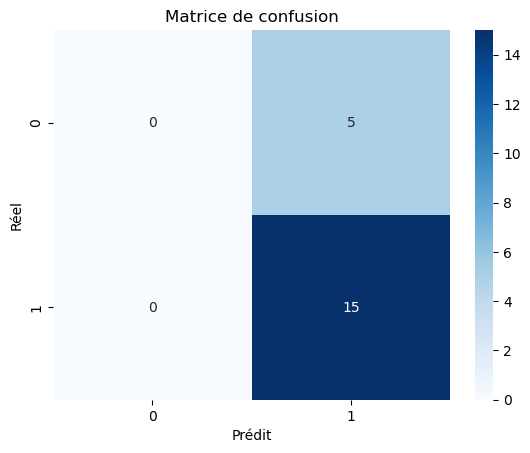

In [ ]:
# Tratement de données 
X = df2[['v1', 'v2']].values
y = df2['label'].values

# 2. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modèle MLP
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 4. Compilation
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# 5. Entraînement
history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0, validation_data=(X_test, y_test))

# 6. Prédiction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1-score: {f1:.4f}")
print("\n📊 Rapport complet :\n")
print(classification_report(y_test, y_pred))

# 8. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

##### Résultat  avec le modèle de vectorisation Doc2vec


In [ ]:
dfDoc2Vec

,X1,X2,polarite
0,0.648915,-2.929711,1
1,1.466017,-1.769099,0
2,1.799427,-2.023257,1
3,2.455747,-3.107562,1
4,1.311184,-1.557100,1
...,...,...,...
95,1.654263,-1.783042,1
96,3.446244,-1.153967,1
97,0.666839,-2.036388,1
98,1.841621,-1.304346,1


c:\Users\FranckOséeDOUNTIOZAB\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
✅ Accuracy: 0.7500
✅ F1-score: 0.8485

📊 Rapport complet :

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.78      0.93      0.85        15

    accuracy                           0.75        20
   macro avg       0.64      0.57      0.57        20
weighted avg       0.71      0.75      0.71        20



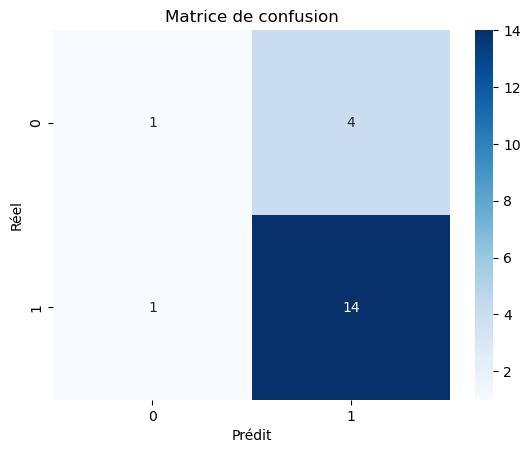

In [ ]:
# Tratement de données 
X = dfDoc2Vec[['X1', 'X2']].values
y = dfDoc2Vec['polarite'].values

# 2. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modèle MLP
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 4. Compilation
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# 5. Entraînement
history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0, validation_data=(X_test, y_test))

# 6. Prédiction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 7. Évaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1-score: {f1:.4f}")
print("\n📊 Rapport complet :\n")
print(classification_report(y_test, y_pred))

# 8. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

#### Travaux

In [ ]:
document_1 = "le chat mange la souris"
document_2 = "le chien regarde le canard"
document_3 = "le canard regarde le chat"
corpus = (document_1, document_2, document_3)

In [ ]:
# construction du vocabulaire
vocabulary = []
for d in corpus:
    for w in d.split(" "):
        if w not in vocabulary:
            vocabulary.append(w)


In [ ]:
vocabulary

['le', 'chat', 'mange', 'la', 'souris', 'chien', 'regarde', 'canard']

In [ ]:
# initialisation de l'histogramme
freq = dict()
for v in vocabulary:
    freq[v] = 0

{'le': 5, 'chat': 2, 'mange': 1, 'la': 1, 'souris': 1, 'chien': 1, 'regarde': 2, 'canard': 2}


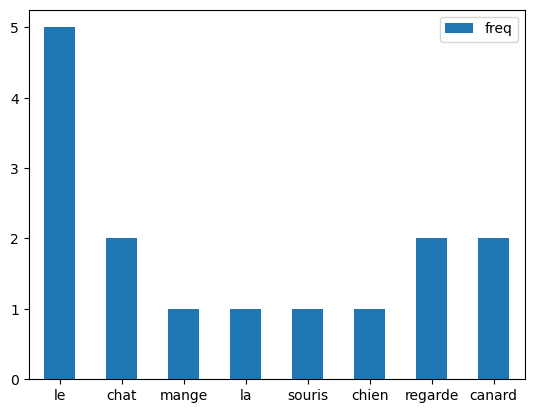

In [ ]:
# comptage des occurrences
for d in corpus:
    for w in d.split(" "):
        freq[w] += 1
print(freq)
df = pd.DataFrame({'freq':freq.values()}, index=freq.keys())
ax = df.plot.bar(rot=0)
plt.show()


In [ ]:
# calcul d'un histogramme par document
import numpy as np
V = len(vocabulary)
D = len(corpus)
tf_idf = np.zeros([D, V])
for i, d in enumerate(corpus):
    for w in d.split(" "):
        j = vocabulary.index(w)
        tf_idf[i,j] += 1
        
print(tf_idf)

[[1. 1. 1. 1. 1. 0. 0. 0.]
 [2. 0. 0. 0. 0. 1. 1. 1.]
 [2. 1. 0. 0. 0. 0. 1. 1.]]


In [ ]:
vocabulary

['le', 'chat', 'mange', 'la', 'souris', 'chien', 'regarde', 'canard']

In [ ]:
corpus

('le chat mange la souris',
 'le chien regarde le canard',
 'le canard regarde le chat')

In [ ]:
enumerate(corpus)

##### Word2vec

In [ ]:
# pip install gensim

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# données d'entraînement tokenisation
p_1=document_1.split(" ")
p_2=document_2.split(" ")
p_3=document_3.split(" ")

corpus=[p_1,p_2,p_3]

In [ ]:
# Paramétrage de l'entraînement
model = Word2Vec(min_count=1, vector_size=5)

In [ ]:
# creation du dictionnaire 
model.build_vocab(corpus) 

In [ ]:
corpus

[['le', 'chat', 'mange', 'la', 'souris'],
 ['le', 'chien', 'regarde', 'le', 'canard'],
 ['le', 'canard', 'regarde', 'le', 'chat']]

In [ ]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

(7, 75)

In [ ]:
print(list(model.wv.index_to_key[ ]))  # Adjust the number to see more


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1734034339.py, line 1)

In [ ]:
model.wv['chat']

array([-0.03632035,  0.0575316 ,  0.01983747, -0.1657043 , -0.18897636],
      dtype=float32)

In [ ]:
#model.wv['souris']
print(model.wv.most_similar(positive=['chien'] ,topn=3))


[('canard', 0.072651706635952), ('regarde', -0.06693901866674423), ('la', -0.08407305926084518)]


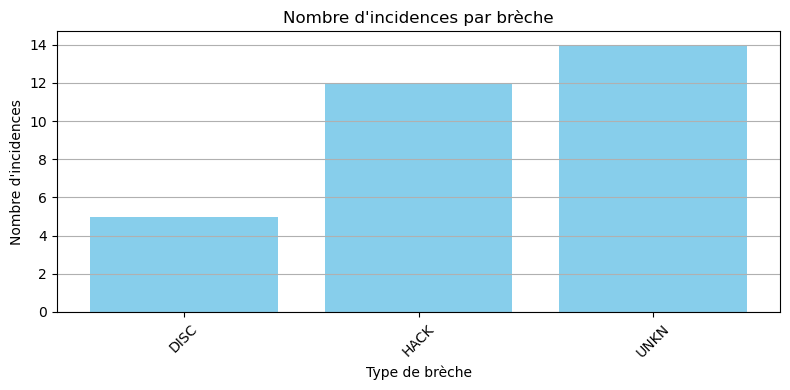

In [ ]:
# Compter les occurrences par année
yearly_counts = df_filtré['breach_type'].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(8, 4))
plt.bar(yearly_counts.index, yearly_counts.values, color='skyblue')

# Ajouter les étiquettes
plt.title("Nombre d'incidences par brèche")
plt.xlabel("Type de brèche")
plt.ylabel("Nombre d'incidences")

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Perceptron 

In [ ]:
corpus

('le chat mange la souris',
 'le chien regarde le canard',
 'le canard regarde le chat')

In [ ]:
d.split()

['le', 'canard', 'regarde', 'le', 'chat']

In [ ]:
d

'le canard regarde le chat'